In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import h5py
import gc

gc.collect()  # Clear unused memory
torch.cuda.empty_cache()

In [11]:
# Load the .h5 file into memory once
h5_file_path_train = r"C:\Users\nadav.k\Documents\DS\DL_classification\classification_data\training_10perc_of_20_subset.h5"
h5_file_path_test = r"C:\Users\nadav.k\Documents\DS\DL_classification\classification_data\testing_10perc_of_20_subset.h5"

# Open the H5 files
h5_train = h5py.File(h5_file_path_train, 'r')
h5_test = h5py.File(h5_file_path_test, 'r')

# Extract datasets
#train_sen1_data = h5_train['sen1']
train_sen2_data = h5_train['sen2']
train_labels = h5_train['label']

#test_sen1_data = h5_test['sen1']
test_sen2_data = h5_test['sen2']
test_labels = h5_test['label']


In [12]:
class Sentinel2Dataset(Dataset):
    def __init__(self, sen2_data, labels):
        self.sen2_data = sen2_data
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        # Extract Sentinel-2 image and label
        sen2_image = self.sen2_data[idx]
        label = self.labels[idx]

        # Convert to PyTorch tensors
        sen2_image = torch.tensor(sen2_image, dtype=torch.float32).permute(2, 0, 1)

        # Convert one-hot encoded label to class index
        label = torch.tensor(label, dtype=torch.float32)
        label = torch.argmax(label).long()

        return sen2_image, label


In [13]:
# Create datasets
train_dataset = Sentinel2Dataset(train_sen2_data, train_labels)
test_dataset = Sentinel2Dataset(test_sen2_data, test_labels)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



In [14]:
class Sentinel2ConvNet(nn.Module):
    def __init__(self, num_classes=17):
        super(Sentinel2ConvNet, self).__init__()

        # Sentinel-2 branch
        self.conv1 = nn.Conv2d(10, 32, kernel_size=3, padding=1)  # Adjusted input channels to 10
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(p=0.25)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjust as per the spatial dimensions of the feature map
        self.fc1_dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc2_dropout = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Sentinel-2 forward pass
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc1_dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_dropout(x)
        x = self.fc3(x)

        return x


In [15]:
# Training function with visualization and memory clearing for Sentinel-2
def train_model(model, train_loader, criterion, optimizer, num_epochs, device='cuda'):
    model.to(device)
    model.train()

    train_losses = []  # List to store training loss for visualization

    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0

        for i, (sen2, labels) in enumerate(train_loader):
            sen2, labels = sen2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sen2)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            epoch_loss += loss.item()

            # Clear memory for each batch (optional but not usually necessary here)
            del outputs, loss

            if i % 100 == 99:  # Print every 100 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100:.4f}')
                running_loss = 0.0

        # Average loss for the epoch
        epoch_loss /= len(train_loader)
        train_losses.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}] Average Loss: {epoch_loss:.4f}')

        # Clear unused memory after each epoch
        torch.cuda.empty_cache()  # Clear GPU memory
        gc.collect()  # Trigger garbage collection for CPU memory

    print('Training complete')

    # Visualization of training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.to(device)
    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for sen2, labels in test_loader:
            sen2, labels = sen2.to(device), labels.to(device)
            outputs = model(sen2)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Calculate accuracy
            predicted = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct_predictions / total_samples

    print(f'Average Test Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    # Visualization (optional)
    plt.figure(figsize=(6, 4))
    plt.bar(['Loss', 'Accuracy'], [avg_loss, accuracy])
    plt.title('Evaluation Results')
    plt.ylabel('Value')
    plt.grid()
    plt.show()

    return avg_loss, accuracy


In [17]:
# Initialize model, loss function, and optimizer
model = Sentinel2ConvNet(num_classes=17)  # Adjust num_classes based on your dataset
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/50] Average Loss: 2.3865
Epoch [2/50] Average Loss: 2.0156
Epoch [3/50] Average Loss: 1.8533
Epoch [4/50] Average Loss: 1.7552
Epoch [5/50] Average Loss: 1.7012
Epoch [6/50] Average Loss: 1.6223
Epoch [7/50] Average Loss: 1.5977
Epoch [8/50] Average Loss: 1.5505
Epoch [9/50] Average Loss: 1.5301
Epoch [10/50] Average Loss: 1.4944
Epoch [11/50] Average Loss: 1.4754
Epoch [12/50] Average Loss: 1.4431
Epoch [13/50] Average Loss: 1.4786
Epoch [14/50] Average Loss: 1.4273
Epoch [15/50] Average Loss: 1.4008
Epoch [16/50] Average Loss: 1.4112
Epoch [17/50] Average Loss: 1.4130
Epoch [18/50] Average Loss: 1.3678
Epoch [19/50] Average Loss: 1.3214
Epoch [20/50] Average Loss: 1.3515
Epoch [21/50] Average Loss: 1.3026
Epoch [22/50] Average Loss: 1.2853
Epoch [23/50] Average Loss: 1.2834
Epoch [24/50] Average Loss: 1.2408
Epoch [25/50] Average Loss: 1.2515
Epoch [26/50] Average Loss: 1.2118
Epoch [27/50] Average Loss: 1.2250
Epoch [28/50] Average Loss: 1.2153
Epoch [29/50] Average Loss: 1

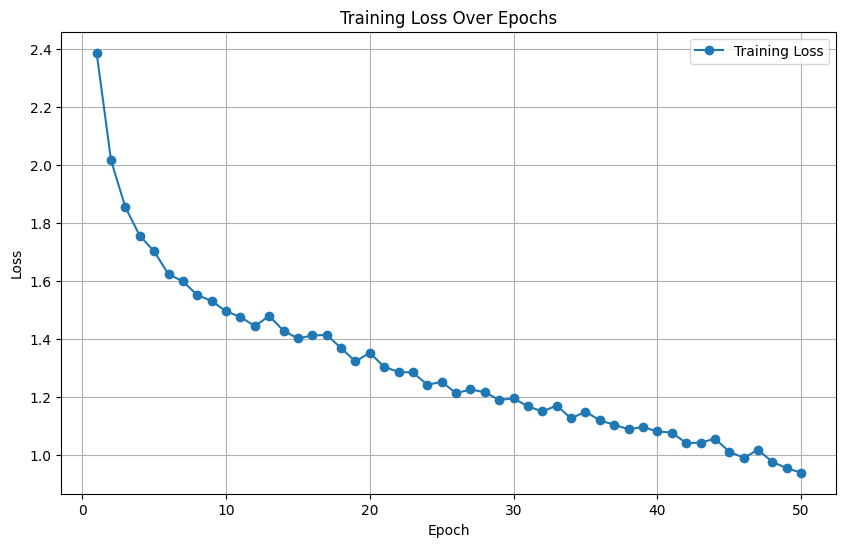

In [18]:
# Train the model
gc.collect()
train_model(model, train_loader, criterion, optimizer, num_epochs=50, device='cuda')

Average Test Loss: 1.0747, Accuracy: 0.6368


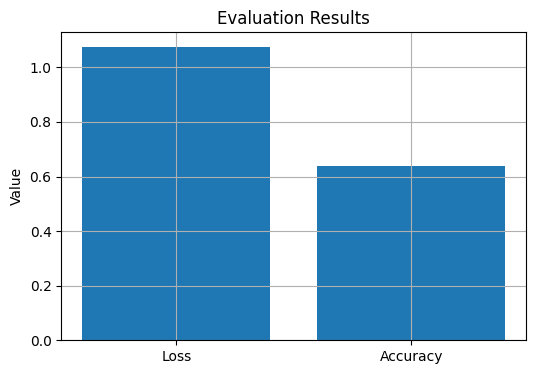

(1.0747092824715834, 0.6368190356919223)

In [19]:
# Perform evaluation
gc.collect()
evaluate_model(model, test_loader, criterion, device='cuda')